In [29]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torch
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import os
warnings.filterwarnings("ignore")

In [3]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic",use_fast=True)
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")

In [7]:
#Loading classes
with open('config.json', 'r') as f:
    config = json.load(f)

labels = config['labels']
color_map = np.zeros((len(labels), 3), dtype=np.uint8)  # Predefined colormap
class_names = []
for idx, label in enumerate(labels):
    color_map[idx] = label['color']
    class_names.append(label['readable'])

In [22]:
for i, class_name in enumerate(class_names):
    print(i, class_name)

0 Bird
1 Ground Animal
2 Curb
3 Fence
4 Guard Rail
5 Barrier
6 Wall
7 Bike Lane
8 Crosswalk - Plain
9 Curb Cut
10 Parking
11 Pedestrian Area
12 Rail Track
13 Road
14 Service Lane
15 Sidewalk
16 Bridge
17 Building
18 Tunnel
19 Person
20 Bicyclist
21 Motorcyclist
22 Other Rider
23 Lane Marking - Crosswalk
24 Lane Marking - General
25 Mountain
26 Sand
27 Sky
28 Snow
29 Terrain
30 Vegetation
31 Water
32 Banner
33 Bench
34 Bike Rack
35 Billboard
36 Catch Basin
37 CCTV Camera
38 Fire Hydrant
39 Junction Box
40 Mailbox
41 Manhole
42 Phone Booth
43 Pothole
44 Street Light
45 Pole
46 Traffic Sign Frame
47 Utility Pole
48 Traffic Light
49 Traffic Sign (Back)
50 Traffic Sign (Front)
51 Trash Can
52 Bicycle
53 Boat
54 Bus
55 Car
56 Caravan
57 Motorcycle
58 On Rails
59 Other Vehicle
60 Trailer
61 Truck
62 Wheeled Slow
63 Car Mount
64 Ego Vehicle
65 Unlabeled


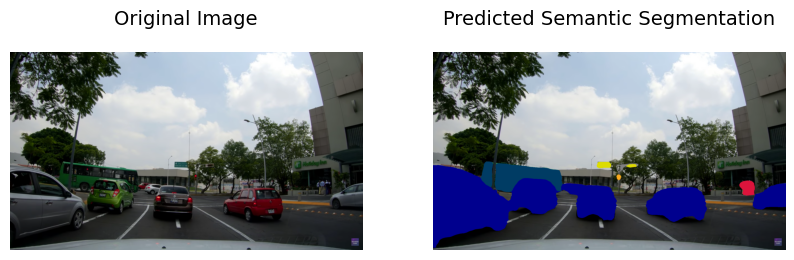

In [27]:
#Inference

image_path = 'data/images/lm.png'
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

#Post-process
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
semantic_map_array = predicted_semantic_map.cpu().numpy()

height, width = semantic_map_array.shape
color_image = np.array(image)

# Apply the colormap
for class_idx in [19,20,46,48,49,50,52,54,55,61]:
    color_image[semantic_map_array == class_idx] = color_map[class_idx]

fig, axes = plt.subplots(1,2,figsize=(10, 10))

axes[0].imshow(image)
axes[0].set_title("Original Image", fontsize=14, pad=20)
axes[0].axis("off")

# Predicted semantic segmentation map
axes[1].imshow(color_image)
axes[1].set_title("Predicted Semantic Segmentation", fontsize=14, pad=20)
axes[1].axis("off")

plt.show()

In [42]:
# Video Semantic Segmentation

video_path = 'data/videos/video1.mov'
output_path = 'data/videos/video1_segmented.mp4'

# Selected classes to highlight (same as image processing)
selected_classes = [19, 20, 46, 48, 49, 50, 52, 54, 55, 61]  # Person, Bicyclist, Traffic Sign Frame, Traffic Light, Traffic Signs, Bicycle, Bus, Car, Truck

# Open video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video properties: {width}x{height}, {fps} fps, {total_frames} frames")

# Define codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_count = 0

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    if frame_count % 10 == 0:  # Progress indicator
        print(f"Processing frame {frame_count}/{total_frames} ({100*frame_count/total_frames:.1f}%)")
    
    # Convert BGR to RGB (OpenCV uses BGR, PIL uses RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert to PIL Image
    image = Image.fromarray(frame_rgb)

    # Process with model
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process
    predicted_semantic_map = processor.post_process_semantic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]]
    )[0]

    
    semantic_map_array = predicted_semantic_map.cpu().numpy()
    
    # Create colored output
    color_frame = frame_rgb.copy()
    
    # Apply the colormap to selected classes
    for class_idx in selected_classes:
        color_frame[semantic_map_array == class_idx] = color_map[class_idx]
    
    # Convert RGB back to BGR for OpenCV
    color_frame_bgr = cv2.cvtColor(color_frame, cv2.COLOR_RGB2BGR)
    
    # Write frame to output video
    out.write(color_frame_bgr)

# Release everything
cap.release()
out.release()

print(f"Video processing complete! Output saved to: {output_path}")


Video properties: 1910x996, 60 fps, 664 frames
Processing frame 10/664 (1.5%)
Processing frame 20/664 (3.0%)
Processing frame 30/664 (4.5%)
Processing frame 40/664 (6.0%)
Processing frame 50/664 (7.5%)
Processing frame 60/664 (9.0%)
Processing frame 70/664 (10.5%)
Processing frame 80/664 (12.0%)
Processing frame 90/664 (13.6%)
Processing frame 100/664 (15.1%)
Processing frame 110/664 (16.6%)
Processing frame 120/664 (18.1%)
Processing frame 130/664 (19.6%)
Processing frame 140/664 (21.1%)
Processing frame 150/664 (22.6%)
Processing frame 160/664 (24.1%)
Processing frame 170/664 (25.6%)
Processing frame 180/664 (27.1%)
Processing frame 190/664 (28.6%)
Processing frame 200/664 (30.1%)
Processing frame 210/664 (31.6%)
Processing frame 220/664 (33.1%)
Processing frame 230/664 (34.6%)
Processing frame 240/664 (36.1%)
Processing frame 250/664 (37.7%)
Processing frame 260/664 (39.2%)
Processing frame 270/664 (40.7%)
Processing frame 280/664 (42.2%)
Processing frame 290/664 (43.7%)
Processing 

In [ ]:
# Display the original and segmented videos side by side
from IPython.display import HTML, display

output_path = 'data/videos/video1_segmented.mp4'

# Display videos side by side using HTML
html_content = f"""
<div style="display: flex; gap: 20px; justify-content: center;">

    <div style="text-align: center;">
        <h3>Segmented Video</h3>
        <video width="640" controls>
            <source src="{output_path}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
</div>
"""

display(HTML(html_content))